# Telco Customer Churn - Python Analysis
### Main Objective:
1. Exploratory Data Anlaysis
2. Data Pre-processing
3. Model Building
4. Model Evaluation
---

### Import Libraries

In [1]:
# Base library
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Selection, cross-validation
from sklearn.model_selection import train_test_split, cross_val_score

# Data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Model
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from functools import partial
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# Ignore warning
import warnings
warnings.simplefilter("ignore")

d:\Program\Coding\Latihan\Python\Telco Customer Churn\Telco-Customer-Churn\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the data

In [2]:
df = pd.read_csv("../data/processed_data/Telco Customer Churn.csv", engine="pyarrow")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No\r
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No\r
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes


In [3]:
# Check the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1000 non-null   object 
 1   gender            1000 non-null   object 
 2   SeniorCitizen     1000 non-null   int64  
 3   Partner           1000 non-null   object 
 4   Dependents        1000 non-null   object 
 5   tenure            1000 non-null   int64  
 6   Contract          1000 non-null   object 
 7   PaperlessBilling  1000 non-null   object 
 8   PaymentMethod     1000 non-null   object 
 9   MonthlyCharges    1000 non-null   float64
 10  TotalCharges      999 non-null    float64
 11  PhoneService      1000 non-null   object 
 12  MultipleLines     1000 non-null   object 
 13  InternetService   1000 non-null   object 
 14  OnlineSecurity    1000 non-null   object 
 15  OnlineBackup      1000 non-null   object 
 16  DeviceProtection  1000 non-null   object 
 

#### Initial Profiling

In [4]:
missing_val = df.isna().sum()
missing_val

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        1
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Churn               0
dtype: int64

In [5]:
df['Churn'] = df['Churn'].str.replace(r'\s+', ' ', regex=True).str.strip()

There's 11 missing values on TotalCharges column. We will drop the missing values.

In [6]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        999 non-null    object 
 1   gender            999 non-null    object 
 2   SeniorCitizen     999 non-null    int64  
 3   Partner           999 non-null    object 
 4   Dependents        999 non-null    object 
 5   tenure            999 non-null    int64  
 6   Contract          999 non-null    object 
 7   PaperlessBilling  999 non-null    object 
 8   PaymentMethod     999 non-null    object 
 9   MonthlyCharges    999 non-null    float64
 10  TotalCharges      999 non-null    float64
 11  PhoneService      999 non-null    object 
 12  MultipleLines     999 non-null    object 
 13  InternetService   999 non-null    object 
 14  OnlineSecurity    999 non-null    object 
 15  OnlineBackup      999 non-null    object 
 16  DeviceProtection  999 non-null    object 
 17  Te

In [7]:
# Check duplicate
df.duplicated().sum()

np.int64(0)

No duplicate found on the dataset.

#### Exploratory Data Analysis
We will conduct:
1. Check Customer's churn distribution
2. Check Customer's gender distribution
3. Check customer's gender distribution by Churn
4. Check customer's internet service type distribution
5. Check customer's contract type
6. Check customer's churn rate by Contract type
7. Check customer's average MonthlyCharges for customers who churned vs. those who didn't
8. Check customer's churn rate by Internet Service type

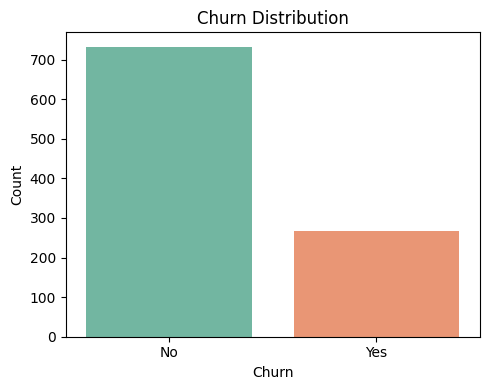

In [8]:
# Check Customer's Churn Distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='Churn', hue='Churn', palette='Set2', legend=False)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

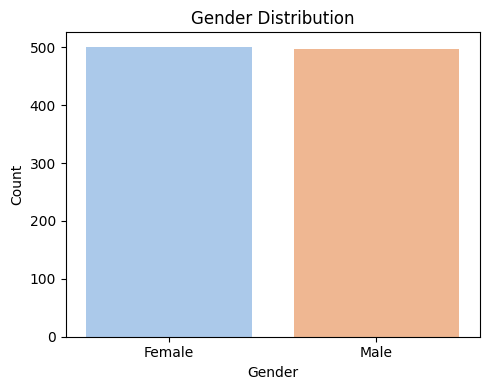

In [9]:
# Check Customer's Gender Distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='gender', hue='gender', palette='pastel', legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


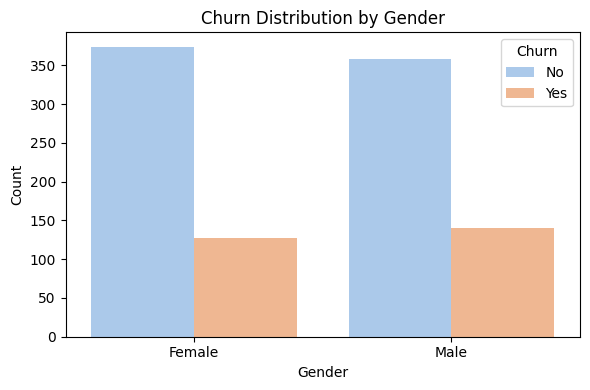

In [10]:
# Check Customer's Gender Distribution by Churn
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', hue='Churn', palette='pastel')
plt.title("Churn Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()

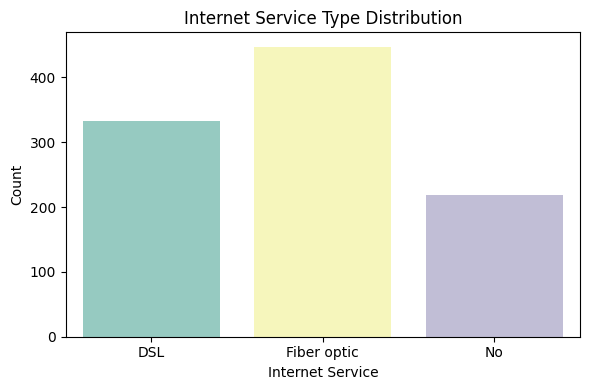

In [11]:
# Check Customer's Internet Service Type Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='InternetService', hue='InternetService', palette='Set3', legend=False)
plt.title("Internet Service Type Distribution")
plt.xlabel("Internet Service")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

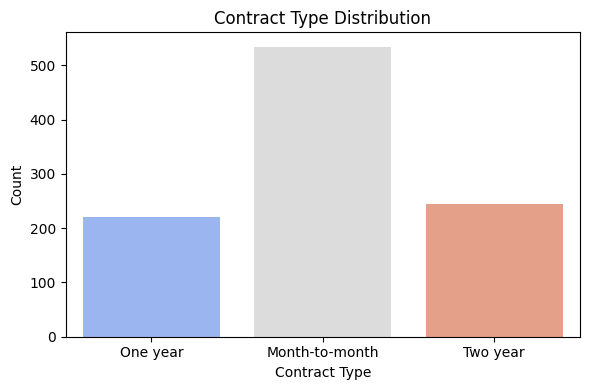

In [12]:
# Contract Type Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Contract', hue='Contract', palette='coolwarm', legend=False)
plt.title("Contract Type Distribution")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

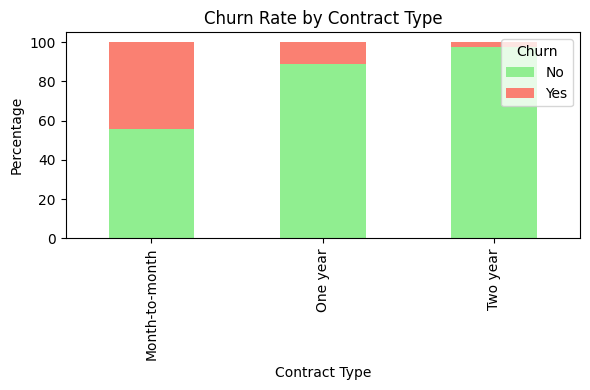

In [13]:
# Churn Rate by Contract Type
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
contract_churn.plot(kind='bar', stacked=True, color=['lightgreen', 'salmon'], figsize=(6, 4))
plt.title("Churn Rate by Contract Type")
plt.ylabel("Percentage")
plt.xlabel("Contract Type")
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()

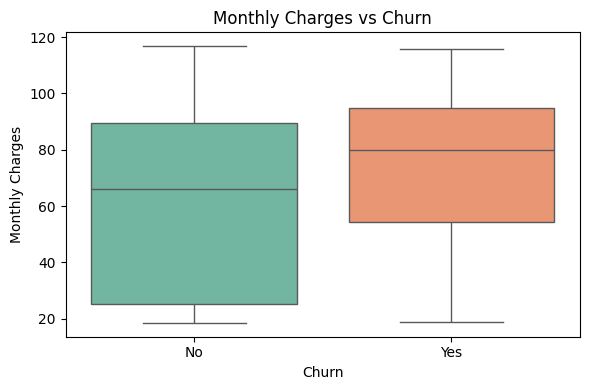

In [14]:
# Avg MonthlyCharges for Churned vs Not Churned
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', hue='Churn', palette='Set2')
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.tight_layout()
plt.show()

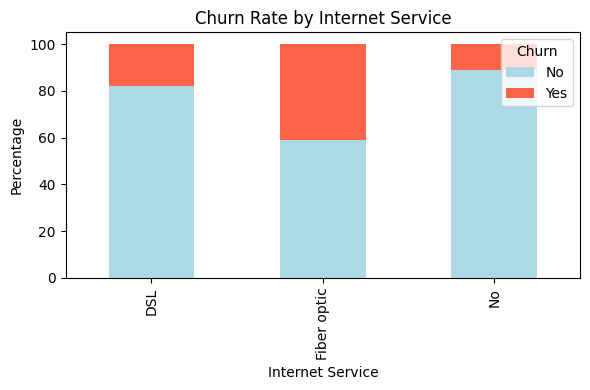

In [15]:
# Churn Rate by Internet Service Type
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
internet_churn.plot(kind='bar', stacked=True, color=['lightblue', 'tomato'], figsize=(6, 4))
plt.title("Churn Rate by Internet Service")
plt.ylabel("Percentage")
plt.xlabel("Internet Service")
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()

#### Exploratory Data Analysis (EDA) Summary

1. Churn Distribution
- The dataset is imbalanced — most customers did **not churn**.
- Use SMOTE or resampling for modeling.
- Accuracy is not reliable; use AUC-ROC, F1, and recall.



2. Gender Distribution
- Male and female customers are nearly balanced.
- Gender may not be a strong predictor of churn.



3. Internet Service Type
- Majority use **Fiber optic** or **DSL**.
- Customers with **no internet** rarely churn.



4. Contract Type
- Most customers are on **Month-to-month** contracts.
- Longer contracts (1–2 years) may reduce churn.



5. Churn Rate by Contract
- **Month-to-month** customers churn the most.
- Loyalty programs for long-term contracts could reduce churn.



6. Monthly Charges vs. Churn
- Churned customers have **higher monthly charges**.
- Price sensitivity may be a churn driver.



7. Churn Rate by Internet Service
- **Fiber optic** users churn more than others.
- Service quality vs. price perception could be an issue.



8. Gender vs. Churn
- No significant difference in churn between genders.
- Gender is likely **not a key feature**.


#### Key Takeaways
- Important features for modeling: `Contract`, `InternetService`, `MonthlyCharges`, `tenure`, `TotalCharges`.
- Data imbalance must be addressed in modeling.
- Focus on high-churn segments (e.g., fiber optic + month-to-month + high cost).

---

#### Data Pre-processing

We will conduct:
- Handle missing values
- Encode categorical features (binary & one-hot)
- Scale numerical features
- Handle outliers (IQR/Z-score)
- Feature engineering (e.g., TotalSpent, HasInternet)
- Balance target classes (SMOTE or other)
- Convert target `Churn` to binary integer
- Stratified train-test split
- Check multicollinearity between features
- Detect and prevent data leakage

Handle any remaining missing values (If there's any)

In [16]:
# Check if there are any extra missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Churn               0
dtype: int64

No remaining/extra missing values on the dataset.

In [17]:
# Check the dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes


We can drop CustomerID column. We will encode the columns that consist of 'Yes' and 'No' values to 0 for No and 1 for Yes. The 'Contract', 'PaymentMethod', 'InternetService', using OneHot Encoder.

In [18]:
# Pre-process function
def preprocess_telco_full(df, handle_outliers=True):
    df = df.copy()

    # 1. Drop irrelevant column
    if 'customerID' in df.columns:
        df.drop('customerID', axis=1, inplace=True)

    # 2. Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(0)

    # 3. Encode target 'Churn'
    if df['Churn'].dtype == 'object':
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # 4. Binary encoding
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
    for col in binary_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # 5. One-hot encoding
    cat_cols = [
        'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
    ]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 6. Feature engineering
    df['TotalSpent'] = df['MonthlyCharges'] * df['tenure']
    df['HasInternet'] = df.get('InternetService_Fiber optic', 0) + df.get('InternetService_DSL', 0)
    df['IsLongContract'] = df.get('Contract_One year', 0) + df.get('Contract_Two year', 0)

    # 7. Handle outliers (IQR capping)
    if handle_outliers:
        numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalSpent']
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df[col] = np.where(df[col] < lower, lower,
                        np.where(df[col] > upper, upper, df[col]))

    return df

# Create new df with applied pre-processing
df_clean = preprocess_telco_full(df, handle_outliers=True)

In [19]:
df_clean.head()

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,PhoneService,Churn,gender_Male,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalSpent,HasInternet,IsLongContract
0,0,1,1,9.0,1,65.6,593.30,1,0,False,...,False,False,True,False,False,False,True,590.4,0,True
1,0,0,0,9.0,0,59.9,542.40,1,0,True,...,False,True,False,False,False,False,True,539.1,0,False
2,0,0,0,4.0,1,73.9,280.85,1,1,True,...,False,False,False,False,False,True,False,295.6,1,False
3,1,1,0,13.0,1,98.0,1237.85,1,1,True,...,False,True,False,False,False,True,False,1274.0,1,False
4,1,1,0,3.0,1,83.9,267.40,1,1,False,...,False,False,False,False,False,False,True,251.7,1,False


<Axes: >

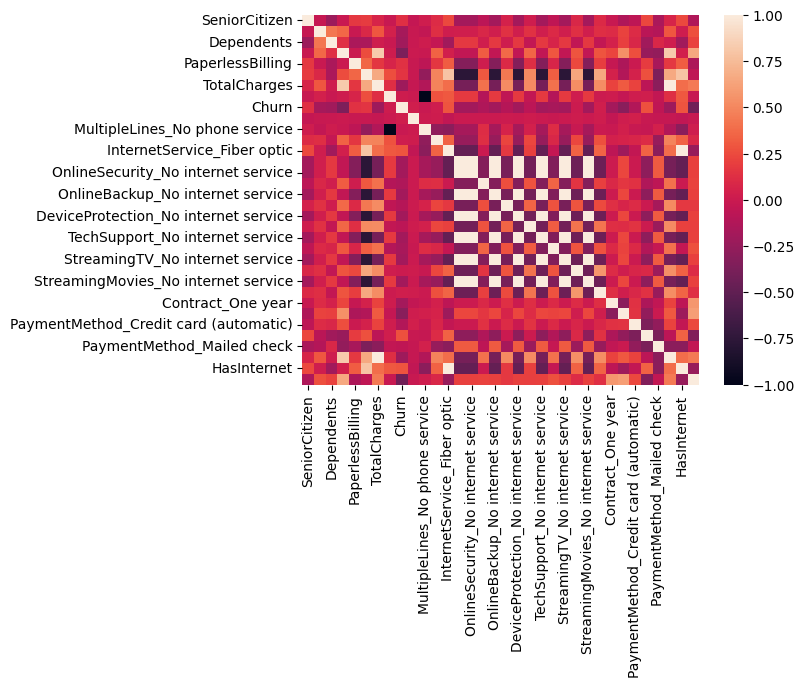

In [20]:
# Correlation analysis
sns.heatmap(df_clean.corr())

Feature Selection and Scaling feature

In [21]:
# Selected column
# selected_features = [
#     'tenure',
#     'MonthlyCharges',
#     'Contract_One year',
#     'Contract_Two year',
#     'InternetService_Fiber optic',
#     'OnlineSecurity',
#     'OnlineBackup',
#     'TechSupport',
#     'DeviceProtection',
#     'PaymentMethod_Electronic check',
#     'PaperlessBilling',
#     'SeniorCitizen',
#     'Partner',
#     'Dependents',
#     'StreamingTV',
#     'StreamingMovies'
# ]

X = df_clean.drop(columns='Churn', axis=1)
y = df_clean['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

---
#### Model Building
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

In [22]:
# Define search param
def define_search_space(trial, model_name):
    search_spaces = {
        "Logistic Regression": lambda: {
            "C": trial.suggest_float("C", 1e-4, 1e2, log=True),
            "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
            "max_iter": trial.suggest_int("max_iter", 500, 2000),
        },
        "Decision Tree": lambda: {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 32),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 32),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        },
        "Random Forest": lambda: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 5, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 16),
        },
        "XGBoost": lambda: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
    }

    if model_name not in search_spaces:
        raise ValueError(f"No search space defined for model: {model_name}")

    return search_spaces[model_name]()

In [23]:
# Get fixed params
def get_fixed_params(model_name):
    fixed = {'random_state': 42}
    if model_name in ["Random Forest", "XGBoost"]:
        fixed['n_jobs'] = -1
    if model_name == "XGBoost":
        fixed['use_label_encoder'] = False
        fixed['eval_metric'] = 'logloss'
    return fixed

In [24]:
# Build Pipeline
def build_pipeline(model_class, params):
    model = model_class(**params)
    return Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

In [25]:
# Objective Function
def objective(trial, model_class, model_name):
    params = define_search_space(trial, model_name)
    params.update(get_fixed_params(model_name))

    pipeline = build_pipeline(model_class, params)
    score = cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1, scoring='roc_auc')
    return score.mean()

In [26]:
# Evaluation metric
def print_eval_report(model_name, y_test, y_pred, y_prob):
    print(f"--- Final Evaluation Results for: {model_name} (After Hyperparameter Tuning) ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC Score on Test Set: {roc_auc_score(y_test, y_prob):.4f}")
    print("=" * 60 + "\n")

In [27]:
# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


🔍 Tuning model: Logistic Regression


Tuning Logistic Regression: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


✅ Best Parameters for Logistic Regression: {'C': 0.0027334911254748833, 'solver': 'saga', 'max_iter': 1440, 'random_state': 42}

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       147
           1       0.54      0.70      0.61        53

    accuracy                           0.77       200
   macro avg       0.71      0.74      0.72       200
weighted avg       0.79      0.77      0.77       200



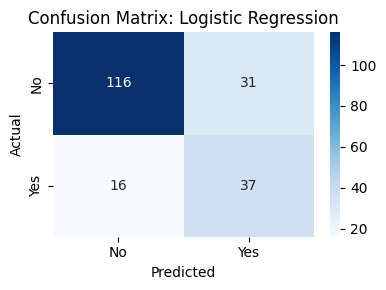


🔍 Tuning model: Decision Tree


Tuning Decision Tree: 100%|██████████| 25/25 [00:00<00:00, 34.13it/s]


✅ Best Parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 23, 'criterion': 'gini', 'random_state': 42}

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.86      0.78      0.81       147
           1       0.51      0.64      0.57        53

    accuracy                           0.74       200
   macro avg       0.68      0.71      0.69       200
weighted avg       0.76      0.74      0.75       200



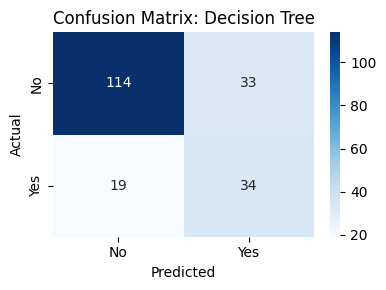


🔍 Tuning model: Random Forest


Tuning Random Forest: 100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


✅ Best Parameters for Random Forest: {'n_estimators': 773, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 16, 'random_state': 42, 'n_jobs': -1}

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       147
           1       0.53      0.58      0.56        53

    accuracy                           0.76       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.76      0.76      0.76       200



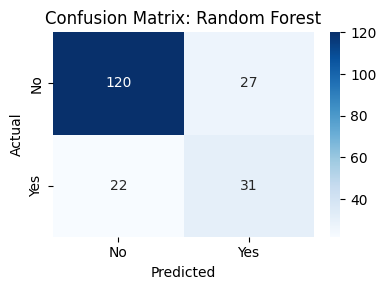


🔍 Tuning model: XGBoost


Tuning XGBoost: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


✅ Best Parameters for XGBoost: {'n_estimators': 166, 'max_depth': 6, 'learning_rate': 0.019972671123413333, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085, 'random_state': 42, 'n_jobs': -1, 'use_label_encoder': False, 'eval_metric': 'logloss'}

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       147
           1       0.60      0.53      0.56        53

    accuracy                           0.78       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.77      0.78      0.78       200



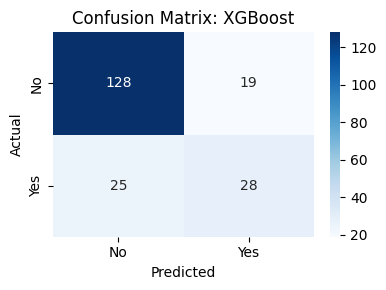

In [28]:
# Model training and tuning
models_to_tune = {
    "Logistic Regression": LogisticRegression,
    "Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "XGBoost": XGBClassifier
}

best_pipelines = {}

model_accuracies = {}

# Tuning and evaluation.
for model_name, model_class in models_to_tune.items():
    print(f"\n🔍 Tuning model: {model_name}")
    n_trials = 25 # You can change how many trials you want to run with Optuna for each model.
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    objective_func = partial(objective, model_class=model_class, model_name=model_name)

    # Progress bar tqdm
    for _ in tqdm(range(n_trials), desc=f"Tuning {model_name}", leave=True):
        study.optimize(objective_func, n_trials=1, catch=(Exception,))

    # Ambil parameter terbaik
    best_params = study.best_params
    best_params.update(get_fixed_params(model_name))
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    # Train model dengan pipeline
    final_pipeline = build_pipeline(model_class, best_params)
    final_pipeline.fit(X_train, y_train)
    best_pipelines[model_name] = final_pipeline

    # Predict dan evaluate
    y_pred = final_pipeline.predict(X_test)
    y_prob = final_pipeline.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Simpan akurasi
    acc = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = acc

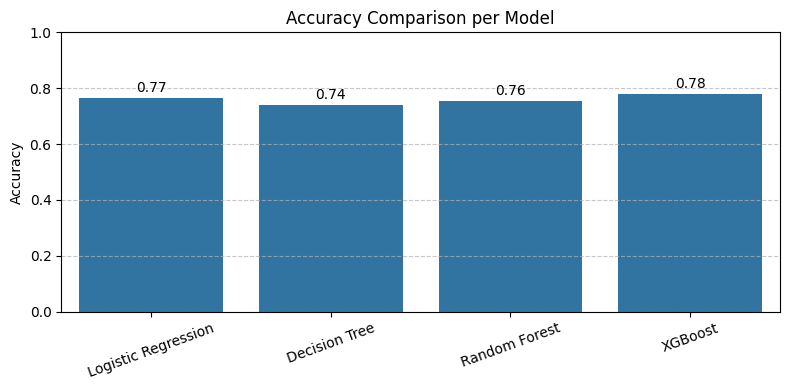

In [29]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))

plt.title("Accuracy Comparison per Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add label
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01,
            f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()